 Backpropagation Lab

In [113]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from numpy import argmax
from numpy import linalg
import math
import copy
import pdb
import sklearn

def sigmoid(x):
  return 1/(1+math.e**-x)

assert sigmoid(0) == .5

def sigmoid_prime(x):
  return x*(1-x)

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [114]:
class MLPClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, hidden_layer_widths, num_input_nodes, num_outputs, lr=.1, momentum=0, shuffle=True, ):
        """ Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes.
        Example:
            mlp = MLPClassifier(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.num_outputs = num_outputs
        self.num_input_nodes = num_input_nodes
        self.hidden_layer_widths = hidden_layer_widths if hidden_layer_widths else [2 * num_input_nodes] 
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.biases = np.ones(np.size(hidden_layer_widths) + 1)
        self.bsf_weights = []
        self.bsf_mse = 0
        self.mse_list = []
        self.num_epochs_ran = 0
        self.avg_scores = []
        
    def add_validation_set(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        #pdb.set_trace()

    def fit(self, X, y, initial_weights_in=None, initial_weights_hi=None, random_weights = False, num_epochs = 10):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        num_inputs = self.num_input_nodes
        num_hidden = self.hidden_layer_widths[0] + 1
        num_outputs = self.num_outputs
      
        if random_weights:
            self.weights_in, self.weights_hi = self.initialize_weights()
        else:
            self.weights_in = initial_weights_in
            self.weights_hi = initial_weights_hi

        prev_in_deltas = np.zeros(self.weights_in.shape)
        prev_hi_deltas = np.zeros(self.weights_hi.shape)
        #pdb.set_trace()
        y_out = np.zeros((num_outputs,1))
        z = None
        iter = 0
        sumerror = 0
        avg_sum_error = 0
        sum_mse = 0
        delta = 0
        num_epochs_no_improv = 0
        sum_score = 0
        
        #pdb.set_trace()
        while self.score(self.X_val, self.y_val) < .90 and iter < num_epochs:
        #while iter < num_epochs and num_epochs_no_improv < 20 and : #Stop if no improvement in 10 epochs
            ### ITERATE THROUGH DATA IN ORDER ###
            
            avg_sum_error = 0
            sum_mse = 0
            sum_score = 0
            for j in range (np.shape(X)[0]):
                x_input = X[j]
                pdb.set_trace()
                target = y[j]
                sum_error = 0 
                ### FEED FORWARD ###

                ### Input Layer Activatons ###
                input_data = X[j,:] # get just the first row of data # Already includes bias
                weights_in_no_b = self.weights_in[:, :-1] #Splice off the last column of weights going to the bias(we don't need them in our dot product for this layer)
                #pdb.set_trace()
                z = np.dot(weights_in_no_b.T, x_input)
                a_out = np.array(list(map(sigmoid, z)))
                #pdb.set_trace()

                ### Hidden Layer Activations
                a_out = np.append(a_out, 1) # add a bias to the node
                z = np.dot(self.weights_hi.T, a_out)
                y_out = np.array(list(map(sigmoid, z))) # compute the final outputs
                #pdb.set_trace()

                ### Backwards Loop ###
 
                ### Output Layer ###

                d_outputs = np.zeros(num_outputs)
                for k in range(num_outputs): # Loop through k output nodes indexing through one-hot-encoding targets
                    # d = (t - a)* a * (1 - a)
                    if (num_outputs == 1):
                        d_outputs[k] = (y[j] - y_out) * y_out * (1 - y_out)
                    else:
                        d_outputs[k] = (y[j][k] - y_out[k]) * y_out[k] * (1 - y_out[k])
                #pdb.set_trace()
                ## Calculate error for Input/Hidden layer
                sum_of_scaled_w = 0
                hidden_layer_errors = np.zeros(num_hidden - 1) #Subtract 1 for the hidden node that doesn't need weights going into it
                for node in range(num_hidden - 1): # loop through every hidden layer node and bias
                    sum_of_scaled_w = 0
                    for k in range(num_outputs): # for each node in previous layer
                        sum_of_scaled_w += d_outputs[k] * self.weights_hi[node][k] * a_out[k] * (1 - a_out[k]) # sum up the error_k * weights_j_k * f'(z)
                    hidden_layer_errors[node] = sum_of_scaled_w
                
      
                ## Adjust output layer/hidden layer weights
                for q in range(num_hidden):
                    for k in range(num_outputs):
                        #pdb.set_trace()
                        layer_change = self.lr * a_out[q] * d_outputs[k]
                        prev_w = prev_hi_deltas[q][k]
                        delta = self.momentum * prev_w + layer_change
                        self.weights_hi[q][k] += delta
                        prev_hi_deltas[q][k] = delta
                        
                        #print("Delta {}{} : {}".format(q, k, delta))
 
                ## Adjust input layer weights
                for q in range(num_inputs):
                    for r in range(num_hidden - 1):
                        #pdb.set_trace()
                        layer_change = self.lr * X[j][q] * hidden_layer_errors[r]
                        prev_w = prev_in_deltas[q][r]
                        delta = self.momentum * prev_w + layer_change
                        self.weights_in[q][r] += delta
                        prev_in_deltas[q][r] = delta
                        #pdb.set_trace()
                        #print("Delta {}{} : {}".format(q, k, delta))
                #pdb.set_trace()

                ####################################### Calculate MSE of test set
                for index in range(len(y_out)):
                    #pdb.set_trace()
                    if (num_outputs == 1):
                        sum_error += (y[j] - y_out)**2
                    else:
                        sum_error += (y[j][index] - y_out[index])**2
                sum_error = sum_error / num_outputs
                #print(sum_error)
                sum_mse += (sum_error)
                #######################################
                ## Calculate the Accuracy from Test Set every iteration
                #pdb.set_trace()
                sum_score += self.score(self.X_val, self.y_val)

                ####################################### Calculate MSE of val set
                # outputs_from_val_set = self.predict(self.X_val)
                # pdb.set_trace()
                # for index in range(len(self.y_val)):
                #     #pdb.set_trace()
                #     sum_error += (self.y_val[index] - y_out[index])**2
                # sum_error = sum_error / num_outputs
                # #print(sum_error)
                # sum_mse += (sum_error)o
                #######################################

                    
            
            avg_sum_error = np.mean(sum_mse)
            self.mse_list.append(avg_sum_error)
            self.avg_scores.append(sum_score / np.shape(X)[0])
            #print("Mean Accuracy for Epoch %", sum_score / np.shape(X)[0])

            if (iter == 0):
                self.bsf_mse = avg_sum_error
            elif avg_sum_error < self.bsf_mse: # If the MSE is better than my previously recorded one
                self.bsf_mse = avg_sum_error #Store bsf mse
                self.bsf_weights = [self.weights_in, self.weights_hi] #store the bsf weights
                num_epochs_no_improv = 0
                #pdb.set_trace()
            else:
                num_epochs_no_improv += 1
            #print('>epoch=%d, error=%.3f' % (iter + 1, avg_sum_error))
            #print("# Epochs with no improvement: ", num_epochs_no_improv)
            #pdb.set_trace()
            if (self.shuffle == True):
                X, y = self._shuffle_data(X,y)
            iter += 1
            # print("Layer 1 \n", self.weights_in)
            # print("Layer 2 \n", self.weights_hi)
            
          
        return self

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        #pdb.set_trace()
        pred = []
        weights_in_no_b = self.weights_in[:, :-1]
        a1 = np.dot(weights_in_no_b.T, X)
        #a1 = X@weights_in_no_b
        a_out = sigmoid(a1) #Compute the activations of the first layer
        a_out = np.append(a_out, 1) # Add on a bias
        z = np.dot(self.weights_hi.T, a_out)
        pred.append(sigmoid(z)) #compute the activation of the hidden layer
        
        return pred


    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        
        ### List of matrices(numpy arrays)
        self.weights = list()

        # Input Layer to Hidden Layer Weights  
        first_matrix = np.random.random((self.num_input_nodes, self.hidden_layer_widths[0] + 1)) 
        num_hidden_layers = self.hidden_layer_widths[0] + 1 # Last is the bias 

        # Hidden Layer to Output Layer
        hidden_matrix = np.random.random((num_hidden_layers, self.num_outputs)) 

        return first_matrix, hidden_matrix

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
                In the MLP you usually have an output node for each class, you would classify by taking the 
                argmax of the activations of your output layer. Then, you can use the standard notion of 
                accuracy (# correct/total) to score your model. (MSE is also a measure of how well your model
                 is doing, but separate from accuracy) (edited) 
        """
        
        correct = 0
        #pdb.set_trace()
        total = np.shape(y)[0] # Total is equal to the number of cols in each row
        for row in range (np.shape(X)[0]): # loop through each row of data X
            #pdb.set_trace()
            y_row = y[row]
            pred_arr = self.predict(X[row])
            if argmax(y_row) == argmax(pred_arr):
                    correct += 1           

        percentage = correct/total
        #print("Accuracy %", percentage)
        return percentage

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        arrX = X
        arry = np.array(y) 
        
        pdb.set_trace()
        y_len = self.num_outputs
        joined = np.concatenate((arrX, arry),axis=1)
        np.random.shuffle(joined)
        n = len(joined[0])
        X = joined[:,:n - y_len]
        y = joined[:, n - y_len :]
        
        return X, y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights


Testing on Back Propegation Hw

In [91]:
!curl https://raw.githubusercontent.com/bjamin5/CS472/main/datasets/hw_for_mlp_lab_test.arff?token=ANEQX3IIZPAJBII4ZKZJCJ3AHCE7O --output hw-data.arff
testdata = arff.loadarff('hw-data.arff')
df = pd.DataFrame(testdata[0])
data = np.array(df)
X = data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
y = np.array([float(x) for x in data[:, 2]])
mod_y = []
for i in range(len(y)):
  if (y[i] == 1):
    mod_y.append([1,0])
  else:
    mod_y.append([0,1])
print(X_bias)
print(y)
print(mod_y)
w1 = np.ones((3,3))
w2 = np.ones((3,1))
mlp = MLPClassifier([3], 3, 1, 1, 0, False)
mlp.fit(X_bias, y, w1, w2, False, 10)
print("Final Layer: \n")
print("Layer 1 \n", mlp.weights_in[:, :-1])
print("Layer 2 \n", mlp.weights_hi)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   110  100   110    0     0    833      0 --:--:-- --:--:-- --:--:--   833
[[0.0 0.0 1.0]
 [0.0 1.0 1.0]]
[1. 0.]
[[1, 0], [0, 1]]


IndexError: ignored

One Hot Encoding Test

Load in Debug Data to test MLP 

In [222]:
num_input_nodes = np.shape(X)[1]
num_input_nodes
X_bias

array([[-0.4, 0.3, 1.0],
       [-0.3, 0.8, 1.0],
       [-0.2, 0.3, 1.0],
       [-0.1, 0.9, 1.0],
       [-0.1, 0.1, 1.0],
       [0.0, -0.2, 1.0],
       [0.1, 0.2, 1.0],
       [0.2, -0.2, 1.0]], dtype=object)

In [84]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output debug-data.arff

data = arff.loadarff('debug-data.arff')
df = pd.DataFrame(data[0])
#df
df.head()
data = np.array(df)
X = data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
y = np.array([float(x) for x in data[:, 2]])

mod_y = []
for i in range(len(y)):
  if (y[i] == 1):
    mod_y.append([1,0])
  else:
    mod_y.append([0,1])

num_input_nodes = np.shape(X_bias)[1]

width_of_hidden = [4] #Not Including bias 
num_outputs = 2

w1 = np.zeros((3,5))
w2 = np.zeros((5,2))
initial_weights = [w1, w2]
#print("X_bias is: \n", X_bias)
#print("Num of outputs is ", num_outputs)
#print("X is:", X)
#print("y is: \n", y)

mlp = MLPClassifier(width_of_hidden, num_input_nodes, num_outputs, .1, .5, False)
mlp.fit(X_bias, mod_y, w1, w2, False, 10)
print("Layer 1 \n", mlp.weights_in[:, :-1])
print("Layer 2 \n", mlp.weights_hi)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   4104      0 --:--:-- --:--:-- --:--:--  4191
>epoch=1, error=2.079
>epoch=2, error=2.058
>epoch=3, error=2.058
>epoch=4, error=2.059
>epoch=5, error=2.059
>epoch=6, error=2.060
>epoch=7, error=2.060
>epoch=8, error=2.061
>epoch=9, error=2.061
>epoch=10, error=2.061
Layer 1 
 [[-0.00018149 -0.00018149 -0.00018149 -0.00018149]
 [ 0.00157468  0.00157468  0.00157468  0.00157468]
 [-0.00788218 -0.00788218 -0.00788218 -0.00788218]]
Layer 2 
 [[-0.01050642  0.01050642]
 [-0.01050642  0.01050642]
 [-0.01050642  0.01050642]
 [-0.01050642  0.01050642]
 [-0.02148778  0.02148778]]


## 1.1 

Debug and Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [9]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output eval-data.arff
data = arff.loadarff('debug-data.arff')
df = pd.DataFrame(data[0])
data = np.array(df)
X = data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
y = np.array([float(x) for x in data[:, 2]])

mod_y = []
for i in range(len(y)):
  if (y[i] == 1):
    mod_y.append([1,0])
  else:
    mod_y.append([0,1])

num_input_nodes = np.shape(X_bias)[1]
width_of_hidden = [4] #Not Including bias 
num_outputs = 2

w1 = np.zeros((3,5))
w2 = np.zeros((5,2))
initial_weights = [w1, w2]


mlp = MLPClassifier(width_of_hidden, num_input_nodes, num_outputs, .1, .5, False)
mlp.fit(X_bias, mod_y, None, None, False, 100)
print("Layer 1 \n", mlp.weights_in[:, :-1])
print("Layer 2 \n", mlp.weights_hi)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   277k      0 --:--:-- --:--:-- --:--:--  277k
>epoch=1, error=0.269
>epoch=2, error=0.265
>epoch=3, error=0.262
>epoch=4, error=0.259
>epoch=5, error=0.257
>epoch=6, error=0.255
>epoch=7, error=0.254
>epoch=8, error=0.252
>epoch=9, error=0.251
>epoch=10, error=0.251
Layer 1 
 [[-0.00018149 -0.00018149 -0.00018149 -0.00018149]
 [ 0.00157468  0.00157468  0.00157468  0.00157468]
 [-0.00788218 -0.00788218 -0.00788218 -0.00788218]]
Layer 2 
 [[-0.01050642  0.01050642]
 [-0.01050642  0.01050642]
 [-0.01050642  0.01050642]
 [-0.01050642  0.01050642]
 [-0.02148778  0.02148778]]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   121k      0 --:--:-- --:--:-- --:--:--  121k
Mean Accuracy for Epoch % 0.3888888888888876
Mean Accuracy for Epoch % 0.37814814814814796
Mean Accuracy for Epoch % 0.33444444444444543
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.33333333333333426
Mean Accuracy for Epoch % 0.334074074074075
Mean Accuracy for Epoch % 0.33518518518518614
Mean Accuracy for Epoch % 0.3359259259259269
Mean Accuracy for Epoch % 0.335

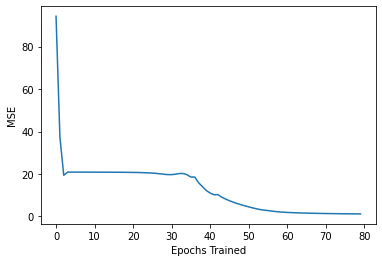

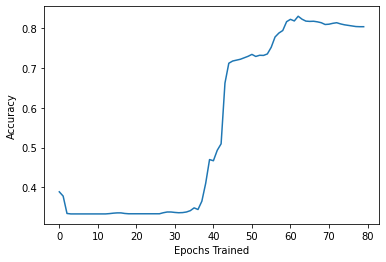

Accuracy of Test Set: 0.7666666666666667


In [213]:
# Iris Classification
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris-data.arff
data = arff.loadarff('iris-data.arff')

df = pd.DataFrame(data[0])
flower_data = np.array(df)

X = flower_data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
y = np.array(flower_data[:, -1])

for j, flower in enumerate(y):
      if flower.decode('utf-8') == "Iris-setosa":
          y[j] = 1
      elif flower.decode('utf-8') == "Iris-versicolor":
          y[j] = 2
      elif flower.decode('utf-8') == "Iris-virginica":
          y[j] = 3

mod_y = []
for i in range(len(y)):
  if (y[i] == 1):
    mod_y.append([1,0,0]) # Iris-setosa
  elif (y[i] == 2):
    mod_y.append([0,1,0]) # Iris-versicolor
  else:
    mod_y.append([0,0,1]) # Iris-virginica

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_bias, mod_y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.15, random_state=1) # 0.25 x 0.8 = 0.2

#w1 = np.zeros((3,5))
#w2 = np.zeros((5,2))
#initial_weights = [w1, w2]

# TEST trin
width_of_hidden = None
num_input_nodes = X_train.shape[1] #4 Not Including bias 
num_outputs = 3
train_mlp = MLPClassifier(width_of_hidden, num_input_nodes, num_outputs, .1, .5, False)
train_mlp.add_validation_set(X_val, y_val)
train_mlp.fit(X_bias, mod_y, None, None, True, 80)

y_accuracy = np.array(train_mlp.avg_scores)
x_epochs = np.array([i for i in range(len(train_mlp.mse_list))])
train_y = np.array(train_mlp.mse_list)
plt.plot(x_epochs,train_y)
plt.xlabel("Epochs Trained")
plt.ylabel("MSE")
plt.show()

plt.plot(x_epochs, y_accuracy)
plt.xlabel("Epochs Trained")
plt.ylabel("Accuracy")
plt.show()

# Print out Test Accuracy
print("Accuracy of Test Set:", train_mlp.score(X_test, y_test))



## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [146]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel-data.arff
data = arff.loadarff('vowel-data.arff')
df = pd.DataFrame(data[0])
del df['Train or Test']
column_trans = make_column_transformer(
    (OneHotEncoder(), ['Speaker Number', 'Sex']),
    remainder='passthrough')
vowel_data = np.array(column_trans.fit_transform(df))
X = vowel_data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
X_bias = X_bias[:, 1:]
y = np.array(vowel_data[:, -1])
dfnew = df.Class
dfnew
data = np.array(dfnew)
mod_y = []
for i, vowel in enumerate(y):
      #pdb.set_trace()
      if vowel.decode('utf-8') == "hUd":
          mod_y.append([1,0,0,0,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hid":
          mod_y.append([0,1,0,0,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hId":
          mod_y.append([0,0,1,0,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hEd":
          mod_y.append([0,0,0,1,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hed":
          mod_y.append([0,0,0,0,1,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hAd":
          mod_y.append([0,0,0,0,0,1,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "had":
          mod_y.append([0,0,0,0,0,0,1,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hYd":
          mod_y.append([0,0,0,0,0,0,0,1,0,0,0,0])
      elif vowel.decode('utf-8') == "hyd":
          mod_y.append([0,0,0,0,0,0,0,0,1,0,0,0])
      elif vowel.decode('utf-8') == "hOd":
          mod_y.append([0,0,0,0,0,0,0,0,0,1,0,0])
      elif vowel.decode('utf-8') == "hod":
          mod_y.append([0,0,0,0,0,0,0,0,0,0,1,0])
      elif vowel.decode('utf-8') == "hud":
          mod_y.append([0,0,0,0,0,0,0,0,0,0,0,1])


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   501k      0 --:--:-- --:--:-- --:--:--  501k


In [148]:
 X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_bias, mod_y, test_size=0.20, random_state=1)
 #X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.15, random_state=1) # 0.25 x 0.8 = 0.2

In [119]:
X_bias.shape

(990, 27)

In [141]:
def gen_train(self, X_train, y_train, num_input_nodes = X_train.shape[1], lr=.1, width_of_hidden=777, num_outputs = 12,
                          num_epochs=100):
    
    train_mlp = MLPClassifier(width_of_hidden, num_input_nodes, num_outputs, lr, .5, False)
    pdb.set_trace()
    train_mlp.add_validation_set(X_val, y_val)
    train_mlp.fit(X_train, y_train, None, None, True, num_epochs)

In [ ]:

num_input_nodes = X_train.shape[1]
width_of_hidden = [2 * num_input_nodes]
num_outputs = 12
lrs = [3,1,.9,.8,.7,.5,.1]
lr_models = []
val_set = [X_val, y_val]
for rate in lrs:
    print("Testing Learning Rate: ", rate)
    cur_model = gen_train(X_train, y_train, num_input_nodes,  lr=rate, width_of_hidden=width_of_hidden, num_outputs=num_outputs,
                           num_epochs=100)
plt.figure()
plt.title("MSE for Validation Set")
for i in range(len(lrs)):
  cur_model = lr_models[i]
  plt.plot(range(cur_model.clf.score(X_test, y_test)), cur_model., label=lrs[i])
plt.legend()
plt.show()


After I couldn't get my code to run the vowel dataset due to one-hot-encoding enduced errors, I used sckit's MLP to see the effect that the learning rates had on the error and optomization of the model. I was able to use my code for the Iris Data set but ran out of time to tweak my code for the vowel data set.
After plotting the error (very close to MSE) the learning rate that was the biggest improved the fastest as expected but tapered off and didn't reach as low of a minimum as the smaller learning rate. Too small of a learning rate caused the line of error to be very linear. .1 was a good balance because it was inbetween the two and had a test set accuracy of %78. The learning weights of 1, .9, .8 suprisingly didn't run for very many epochs before the model stopped training due to the error not decreasing enough. This is probably because they overshot the minimum.

In [153]:
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import mean_squared_error
clf1 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 50, learning_rate_init=0.3, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=55, validation_fraction=.15)
clf1.fit(X_train, y_train)
print("Training set score: %f" % clf1.score(X_train, y_train))
print("Test set score: %f" % clf1.score(X_test, y_test))

clf2 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 50, learning_rate_init=1, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=55, validation_fraction=.15)
clf2.fit(X_train, y_train)
print("Training set score: %f" % clf2.score(X_train, y_train))
print("Test set score: %f" % clf2.score(X_test, y_test))

clf3 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 50, learning_rate_init=.9, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=55, validation_fraction=.15)
clf3.fit(X_train, y_train)
print("Training set score: %f" % clf3.score(X_train, y_train))
print("Test set score: %f" % clf3.score(X_test, y_test))

clf4 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 50, learning_rate_init=.8, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=55, validation_fraction=.15)
clf4.fit(X_train, y_train)
print("Training set score: %f" % clf4.score(X_train, y_train))
print("Test set score: %f" % clf4.score(X_test, y_test))

clf5 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 20, learning_rate_init=0.1, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=55, validation_fraction=.15)
clf5.fit(X_train, y_train)
print("Training set score: %f" % clf5.score(X_train, y_train))
print("Test set score: %f" % clf5.score(X_test, y_test))



Iteration 1, loss = 7.65110912
Iteration 2, loss = 4.55370006
Iteration 3, loss = 3.79311466
Iteration 4, loss = 3.79546334
Iteration 5, loss = 3.51549395
Iteration 6, loss = 3.38214137
Iteration 7, loss = 3.28731967
Iteration 8, loss = 3.14051939
Iteration 9, loss = 3.04026555
Iteration 10, loss = 2.96199239
Iteration 11, loss = 2.88354609
Iteration 12, loss = 2.81771278
Iteration 13, loss = 2.78934638
Iteration 14, loss = 2.71898585
Iteration 15, loss = 2.67734432
Iteration 16, loss = 2.65653899
Iteration 17, loss = 2.62444181
Iteration 18, loss = 2.55191430
Iteration 19, loss = 2.51863408
Iteration 20, loss = 2.47558230
Iteration 21, loss = 2.44351620
Iteration 22, loss = 2.44197987
Iteration 23, loss = 2.39785971
Iteration 24, loss = 2.38655255
Iteration 25, loss = 2.34615059
Iteration 26, loss = 2.31524341
Iteration 27, loss = 2.31186859
Iteration 28, loss = 2.28593317
Iteration 29, loss = 2.27269571
Iteration 30, loss = 2.25091112
Iteration 31, loss = 2.23317082
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 21, loss = 3.54688777
Iteration 22, loss = 3.57586006
Iteration 23, loss = 3.61248987
Iteration 24, loss = 3.57523744
Iteration 25, loss = 3.60077363
Iteration 26, loss = 3.49352085
Iteration 27, loss = 3.56773491
Iteration 28, loss = 3.53966740
Iteration 29, loss = 3.59182968
Iteration 30, loss = 3.72630754
Iteration 31, loss = 3.66298628
Iteration 32, loss = 3.63488740
Iteration 33, loss = 3.85437335
Iteration 34, loss = 3.71031636
Iteration 35, loss = 3.64116762
Iteration 36, loss = 3.83800135
Iteration 37, loss = 3.68714056
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training set score: 0.000000
Test set score: 0.000000
Iteration 1, loss = 17.83595739
Iteration 2, loss = 13.87470814
Iteration 3, loss = 9.19638321
Iteration 4, loss = 11.54014399
Iteration 5, loss = 9.95651780
Iteration 6, loss = 5.64562967
Iteration 7, loss = 5.37921354
Iteration 8, loss = 5.39095202
Iteration 9, loss = 4.34724856
Iteration 10, loss = 4.1953719

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



After plotting and printing out the errors of MLP's with different learning rates it became apparent that such a small change in the LR and it makes a big difference. This may be one of the most important parameters for our ML models. As I said above too small of learning rate and the progress is slow, and linear. Too large of a learning rate and the progress is quick but doesn't find as low of a minumum error as a medium learning rate. 

The vowel set is far more difficult than the iris data set for a couple of reasons. Features of a plant are measurable and they are more distinct form eachother. Features from sound are difficult to extract and train a neural network with. To that extent there were many more features in the Vowel Dataset as we can't be sure what features will have the highest correlation to the response variable, in this case what we are predicting. The Vowel dataset also mixed catagorical data with numerical data. This required one-hot-encoding and increased our number of inputs. The more inputs we have the more input nodes and weights our model has to calculate and store. It also had 12 outputs which decreased the chances of the model guessing correctly when with the iris datat there was a 30 percent chance it could guess correctly.

The Vowel test set had an accuracy of 0.78. The Iris data set had an accuracy of 76 percent. With more time I could have adjusted the parameters for the Iris data set to yeild a higher accuracy. The accuracy of the vowel test set was naturally higher because of optomizing the lr.



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

A learning rate of .1 scored the best


In [163]:



clf11 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 50, learning_rate_init=1, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=100, validation_fraction=.15)
clf11.fit(X_train, y_train)

print("Test set score: %f" % clf11.score(X_test, y_test))

clf13 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 50, learning_rate_init=.9, momentum=.5,n_iter_no_change = 10, hidden_layer_sizes=20, validation_fraction=.15)
clf13.fit(X_train, y_train)

print("Test set score: %f" % clf13.score(X_test, y_test))

Iteration 1, loss = 2.16104405
Iteration 2, loss = 48.45086913
Iteration 3, loss = 19.95229431
Iteration 4, loss = 18.04025371
Iteration 5, loss = 12.71379035
Iteration 6, loss = 7.23994378
Iteration 7, loss = 11.69363407
Iteration 8, loss = 14.63573263
Iteration 9, loss = 14.08560735
Iteration 10, loss = 15.76526748
Iteration 11, loss = 13.04171806
Iteration 12, loss = 8.70054470
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test set score: 0.000000
Iteration 1, loss = 1.95839609
Iteration 2, loss = 8.48425032
Iteration 3, loss = 2.92829120
Iteration 4, loss = 4.40933296
Iteration 5, loss = 4.44127264
Iteration 6, loss = 1.88722684
Iteration 7, loss = 1.84330715
Iteration 8, loss = 2.85641728
Iteration 9, loss = 2.90482185
Iteration 10, loss = 2.12111426
Iteration 11, loss = 1.25086142
Iteration 12, loss = 1.23488918
Iteration 13, loss = 1.79004399
Iteration 14, loss = 1.92617991
Iteration 15, loss = 1.49983948
Iteration 16, loss = 1.0519880

## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- You are trying to see how much momentum speeds up learning. 

*Discuss Momentum here*



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [158]:
# Iris Classification
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris-data.arff
data = arff.loadarff('iris-data.arff')

df = pd.DataFrame(data[0])
flower_data = np.array(df)

X = flower_data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
y = np.array(flower_data[:, -1])

for j, flower in enumerate(y):
      if flower.decode('utf-8') == "Iris-setosa":
          y[j] = 1
      elif flower.decode('utf-8') == "Iris-versicolor":
          y[j] = 2
      elif flower.decode('utf-8') == "Iris-virginica":
          y[j] = 3

mod_y = []
for i in range(len(y)):
  if (y[i] == 1):
    mod_y.append([1,0,0]) # Iris-setosa
  elif (y[i] == 2):
    mod_y.append([0,1,0]) # Iris-versicolor
  else:
    mod_y.append([0,0,1]) # Iris-virginica

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_bias, mod_y, test_size=0.20, random_state=1)


clf6 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 20, learning_rate_init=0.1, momentum=.5,n_iter_no_change = 30, hidden_layer_sizes=10, validation_fraction=.15)
clf6.fit(X_train, y_train)
#print("Training set score: %f" % clf6.score(X_train, y_train))
print("Test set score: %f" % clf6.score(X_test, y_test))

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel-data.arff
data = arff.loadarff('vowel-data.arff')
df = pd.DataFrame(data[0])
del df['Train or Test']
column_trans = make_column_transformer(
    (OneHotEncoder(), ['Speaker Number', 'Sex']),
    remainder='passthrough')
vowel_data = np.array(column_trans.fit_transform(df))
X = vowel_data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
X_bias = X_bias[:, 1:]
y = np.array(vowel_data[:, -1])
dfnew = df.Class
dfnew
data = np.array(dfnew)
mod_y = []
for i, vowel in enumerate(y):
      #pdb.set_trace()
      if vowel.decode('utf-8') == "hUd":
          mod_y.append([1,0,0,0,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hid":
          mod_y.append([0,1,0,0,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hId":
          mod_y.append([0,0,1,0,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hEd":
          mod_y.append([0,0,0,1,0,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hed":
          mod_y.append([0,0,0,0,1,0,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hAd":
          mod_y.append([0,0,0,0,0,1,0,0,0,0,0,0])
      elif vowel.decode('utf-8') == "had":
          mod_y.append([0,0,0,0,0,0,1,0,0,0,0,0])
      elif vowel.decode('utf-8') == "hYd":
          mod_y.append([0,0,0,0,0,0,0,1,0,0,0,0])
      elif vowel.decode('utf-8') == "hyd":
          mod_y.append([0,0,0,0,0,0,0,0,1,0,0,0])
      elif vowel.decode('utf-8') == "hOd":
          mod_y.append([0,0,0,0,0,0,0,0,0,1,0,0])
      elif vowel.decode('utf-8') == "hod":
          mod_y.append([0,0,0,0,0,0,0,0,0,0,1,0])
      elif vowel.decode('utf-8') == "hud":
          mod_y.append([0,0,0,0,0,0,0,0,0,0,0,1])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_bias, mod_y, test_size=0.20, random_state=1)

clf7 = MLP(random_state=1, activation='logistic', max_iter=100, verbose= 20, learning_rate_init=0.1, momentum=.5,n_iter_no_change = 30, hidden_layer_sizes=11, validation_fraction=.15)
clf7.fit(X_train, y_train)
#print("Training set score: %f" % clf7.score(X_train, y_train))
print("Test set score: %f" % clf7.score(X_test, y_test))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   149k      0 --:--:-- --:--:-- --:--:--  149k
Iteration 1, loss = 2.15883950
Iteration 2, loss = 1.92626608
Iteration 3, loss = 1.86100562
Iteration 4, loss = 1.82573675
Iteration 5, loss = 1.77693144
Iteration 6, loss = 1.70844475
Iteration 7, loss = 1.63689281
Iteration 8, loss = 1.57365335
Iteration 9, loss = 1.50793949
Iteration 10, loss = 1.43806553
Iteration 11, loss = 1.37310426
Iteration 12, loss = 1.30566612
Iteration 13, loss = 1.23358713
Iteration 14, loss = 1.15971273
Iteration 15, loss = 1.09490028
Iteration 16, loss = 1.05933363
Iteration 17, loss = 1.03069751
Iteration 18, loss = 0.98520674
Iteration 19, loss = 0.95353991
Iteration 20, loss = 0.93762282
Iteration 21, loss = 0.91574708
Iteration 22, loss = 0.89081315
Iteration 23, loss = 0.87346298
Iteration 24, loss = 0.84405864
Iter

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   444k      0 --:--:-- --:--:-- --:--:--  444k
Iteration 1, loss = 5.28941087
Iteration 2, loss = 3.91427528
Iteration 3, loss = 3.68198304
Iteration 4, loss = 3.42806476
Iteration 5, loss = 3.41170129
Iteration 6, loss = 3.39106481
Iteration 7, loss = 3.37714395
Iteration 8, loss = 3.35459598
Iteration 9, loss = 3.33897726
Iteration 10, loss = 3.31579061
Iteration 11, loss = 3.28527155
Iteration 12, loss = 3.28029230
Iteration 13, loss = 3.26607502
Iteration 14, loss = 3.25117991
Iteration 15, loss = 3.23308906
Iteration 16, loss = 3.21233505
Iteration 17, loss = 3.17599616
Iteration 18, loss = 3.12374067
Iteration 19, loss = 3.07798053
Iteration 20, loss = 3.04503803
Iteration 21, loss = 3.01922603
Iteration 22, loss = 2.99371959
Iteration 23, loss = 2.96300299
Iteration 24, loss = 2.94491819
Iter

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


I experimented with the number of hidden layers and got the following results.
 Iris Data: 11 Layers -> 1.0
Vowel Data: 11 Layers -> .43
I wanted to see what happend to the accuracy as I compressed the data vs expanded it. In the case of the Iris data set its accuracy increased a lot but it definetally overfit the data. 
Another observation I had was the when using early stopping, higher learning rates and very low ones would exit sooner because they either passed the minimum or they didn't progress fast enough. 

          


## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [162]:
# Iris Classification
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris-data.arff
data = arff.loadarff('iris-data.arff')

df = pd.DataFrame(data[0])
flower_data = np.array(df)

X = flower_data[:,0:-1]
numCols = np.shape(X)[0]
X_bias = np.concatenate((X,np.ones((numCols,1))),axis=1)
y = np.array(flower_data[:, -1])

for j, flower in enumerate(y):
      if flower.decode('utf-8') == "Iris-setosa":
          y[j] = 1
      elif flower.decode('utf-8') == "Iris-versicolor":
          y[j] = 2
      elif flower.decode('utf-8') == "Iris-virginica":
          y[j] = 3

mod_y = []
for i in range(len(y)):
  if (y[i] == 1):
    mod_y.append([1,0,0]) # Iris-setosa
  elif (y[i] == 2):
    mod_y.append([0,1,0]) # Iris-versicolor
  else:
    mod_y.append([0,0,1]) # Iris-virginica

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_bias, mod_y, test_size=0.20, random_state=1)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(5,5,5), (3,3), (8,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  40901      0 --:--:-- --:--:-- --:--:-- 40901
Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (8,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.217 (+/-0.613) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate': 'constant', 'solver': 'sgd'}
0.000 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate': 'constant', 'solver': 'adam'}
0.000 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.192 (+/-0.542) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.100 (+/-0.283) for {'activation': 'tanh', 'alpha': 0.0001, 'hid

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


In [ ]:
# Optional grid and random search

*Discuss findings here*